In [2]:
# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.dpi"] = 120

# One knob: number of PCs used for the runs you're comparing
NUM_PCS = 30

# Where outputs go
OUTDIR = f"results/overall_{NUM_PCS}_pcs"
os.makedirs(OUTDIR, exist_ok=True)

# ---- Per-model summary CSV paths ----
PATHS = {
    "Dummy":        f"01_simple_baselines/results/dummy_regressor/dummy_regressor_results_{NUM_PCS}_pcs.csv",
    "Ridge":        f"01_simple_baselines/results/ridge_regression/ridge_regression_results_{NUM_PCS}_pcs.csv",
    "ElasticNet":   f"01_simple_baselines/results/elastic_net/voom_{NUM_PCS}_pcs.csv",
    "RandomForest": f"02_complex_baselines/results/rf/voom_{NUM_PCS}_pcs.csv",
    "XGBoost":      f"02_complex_baselines/results/xgboost/voom_{NUM_PCS}_pcs.csv",
    "MLP":          f"02_complex_baselines/results/mlp/voom_{NUM_PCS}_pcs.csv",
}


In [3]:
# %%
def load_with_model_label(path: str, model_name: str) -> pd.DataFrame:
    """Load one CSV, attach Model label, and normalize columns."""
    df = pd.read_csv(path)
    df["Model"] = model_name
    # Normalize odd characters / whitespace in column names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)

    expected = {"DRUG_ID", "n_samples", "rmse_mean", "rmse_std", "r2_mean", "r2_std"}
    missing = expected - set(df.columns)

    # Light alignment for common alt names
    if "drug_id" in df.columns and "DRUG_ID" in missing:
        df["DRUG_ID"] = df["drug_id"]; missing.remove("DRUG_ID")
    if "n" in df.columns and "n_samples" in missing:
        df["n_samples"] = df["n"]; missing.remove("n_samples")

    for m in list(missing):
        df[m] = np.nan

    keep = ["DRUG_ID", "n_samples", "rmse_mean", "rmse_std", "r2_mean", "r2_std", "Model"]
    df = df[[c for c in keep if c in df.columns]].copy()
    return df

frames = []
for model, path in PATHS.items():
    if not os.path.exists(path):
        print(f"⏭️  {model}: file not found -> {path}")
        continue
    try:
        df = load_with_model_label(path, model)
        df["NUM_PCS"] = NUM_PCS
        frames.append(df)
        print(f"✅ Loaded {model}: {df.shape}")
    except Exception as e:
        print(f"❌ Failed to load {model} from {path}: {e}")

if not frames:
    raise FileNotFoundError("No model summaries loaded. Check PATHS.")

all_df = pd.concat(frames, ignore_index=True)

# Ensure numeric
for col in ["rmse_mean", "r2_mean", "n_samples", "rmse_std", "r2_std"]:
    if col in all_df.columns:
        all_df[col] = pd.to_numeric(all_df[col], errors="coerce")

print("\nPreview:")
all_df.head()


✅ Loaded Dummy: (697, 8)
✅ Loaded Ridge: (697, 8)
✅ Loaded ElasticNet: (697, 8)
✅ Loaded RandomForest: (697, 8)
✅ Loaded XGBoost: (697, 8)
✅ Loaded MLP: (697, 8)

Preview:


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std,Model,NUM_PCS
0,1,NaN,1.108986,0.171402,-0.036364,0.032988,Dummy,30
1,3,NaN,2.003308,0.114150,-0.008861,0.012807,Dummy,30
2,5,NaN,1.650569,0.192533,-0.034595,0.036549,Dummy,30
3,6,NaN,0.887511,0.126332,-0.020691,0.029201,Dummy,30
4,9,NaN,1.462640,0.060871,-0.002795,0.002771,Dummy,30


In [4]:
# %%
filtered_df = all_df[
    (all_df["rmse_mean"] <= 3.5) &
    (all_df["r2_mean"] >= -1)
].dropna(subset=["rmse_mean", "r2_mean"]).copy()

print(f"Original rows: {len(all_df)} | Filtered rows: {len(filtered_df)}")
filtered_df["Model"].value_counts()


Original rows: 4182 | Filtered rows: 3744


Model
Dummy           697
Ridge           697
ElasticNet      697
RandomForest    697
XGBoost         697
MLP             259
Name: count, dtype: int64

In [5]:
# %%
combined_path = os.path.join(OUTDIR, f"combined_model_summaries_{NUM_PCS}_pcs.csv")
filtered_path = os.path.join(OUTDIR, f"combined_model_summaries_filtered_{NUM_PCS}_pcs.csv")

all_df.to_csv(combined_path, index=False)
filtered_df.to_csv(filtered_path, index=False)

print("Saved:")
print(" -", combined_path)
print(" -", filtered_path)


Saved:
 - results/overall_30_pcs/combined_model_summaries_30_pcs.csv
 - results/overall_30_pcs/combined_model_summaries_filtered_30_pcs.csv


/tmp/ipykernel_2185557/381625116.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


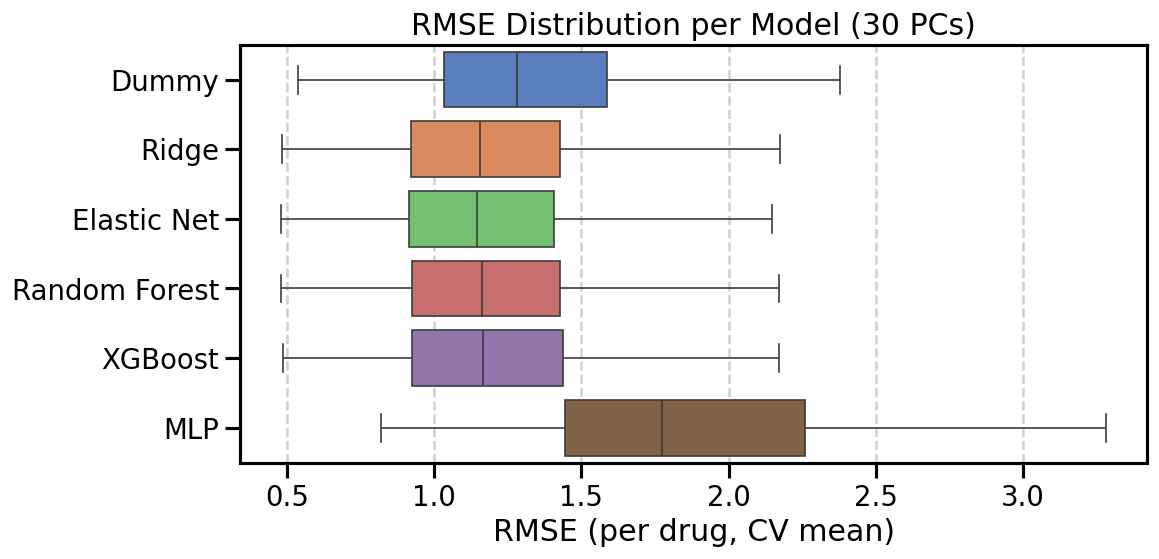

/tmp/ipykernel_2185557/381625116.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


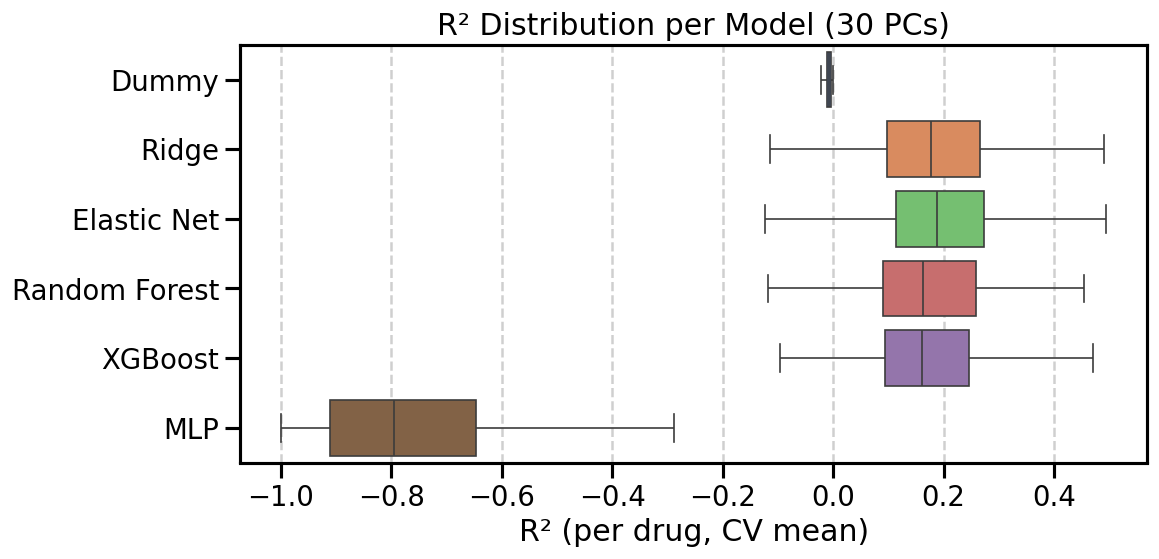

In [6]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

# Pretty names for plotting (keep original 'Model' for calcs)
pretty_map = {
    "RandomForest": "Random Forest",
    "ElasticNet":   "Elastic Net",
    "XGBoost":      "XGBoost",
    "Dummy":        "Dummy",
    "Ridge":        "Ridge",
    "MLP":          "MLP",
}
filtered_df["ModelPretty"] = filtered_df["Model"].map(pretty_map).fillna(filtered_df["Model"])

# consistent order on y-axis
order = ["Dummy", "Ridge", "ElasticNet", "RandomForest", "XGBoost", "MLP"]
order_pretty = [pretty_map[m] for m in order]

# --- RMSE ---
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=filtered_df,
    x="rmse_mean",
    y="ModelPretty",
    order=order_pretty,
    palette="muted",
    showfliers=False
)
plt.title(f"RMSE Distribution per Model ({NUM_PCS} PCs)")
plt.xlabel("RMSE (per drug, CV mean)")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- R² ---
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=filtered_df,
    x="r2_mean",
    y="ModelPretty",
    order=order_pretty,
    palette="muted",
    showfliers=False
)
plt.title(f"R² Distribution per Model ({NUM_PCS} PCs)")
plt.xlabel("R² (per drug, CV mean)")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
# %%
summary = (
    filtered_df
    .groupby("Model")[["rmse_mean", "r2_mean"]]
    .agg(["mean", "std", "median"])
    .round(4)
    .sort_values(("r2_mean", "mean"), ascending=False)
)

summary_path = os.path.join(OUTDIR, f"summary_stats_{NUM_PCS}_pcs.csv")
summary.to_csv(summary_path)
print("Saved summary to:", summary_path)
summary


Saved summary to: results/overall_30_pcs/summary_stats_30_pcs.csv


rmse_mean                 r2_mean                
                  mean     std  median    mean     std  median
Model                                                         
ElasticNet      1.1901  0.3607  1.1465  0.1953  0.1046  0.1884
Ridge           1.2015  0.3645  1.1567  0.1765  0.1299  0.1768
RandomForest    1.2047  0.3626  1.1622  0.1733  0.1094  0.1621
XGBoost         1.2100  0.3666  1.1659  0.1696  0.0992  0.1611
Dummy           1.3441  0.4203  1.2825 -0.0102  0.0138 -0.0074
MLP             1.8619  0.5273  1.7726 -0.7592  0.1895 -0.7959

In [8]:
# %%
counts_per_drug = filtered_df.groupby("DRUG_ID")["Model"].nunique()
valid_drugs = counts_per_drug[counts_per_drug >= 2].index

r2_pivot = (
    filtered_df[filtered_df["DRUG_ID"].isin(valid_drugs)]
    .pivot_table(index="DRUG_ID", columns="Model", values="r2_mean", aggfunc="mean")
)

winners = r2_pivot.idxmax(axis=1).value_counts().sort_values(ascending=False)
winners_df = winners.rename_axis("Model").to_frame(name="WinCount")
winners_df["WinPct"] = (100 * winners_df["WinCount"] / winners_df["WinCount"].sum()).round(1)

winners_path = os.path.join(OUTDIR, f"per_drug_winners_{NUM_PCS}_pcs.csv")
winners_df.to_csv(winners_path)

print("Saved winners table to:", winners_path)
winners_df


Saved winners table to: results/overall_30_pcs/per_drug_winners_30_pcs.csv


,WinCount,WinPct
Model,,
ElasticNet,494,70.9
RandomForest,104,14.9
XGBoost,49,7.0
Ridge,49,7.0
Dummy,1,0.1


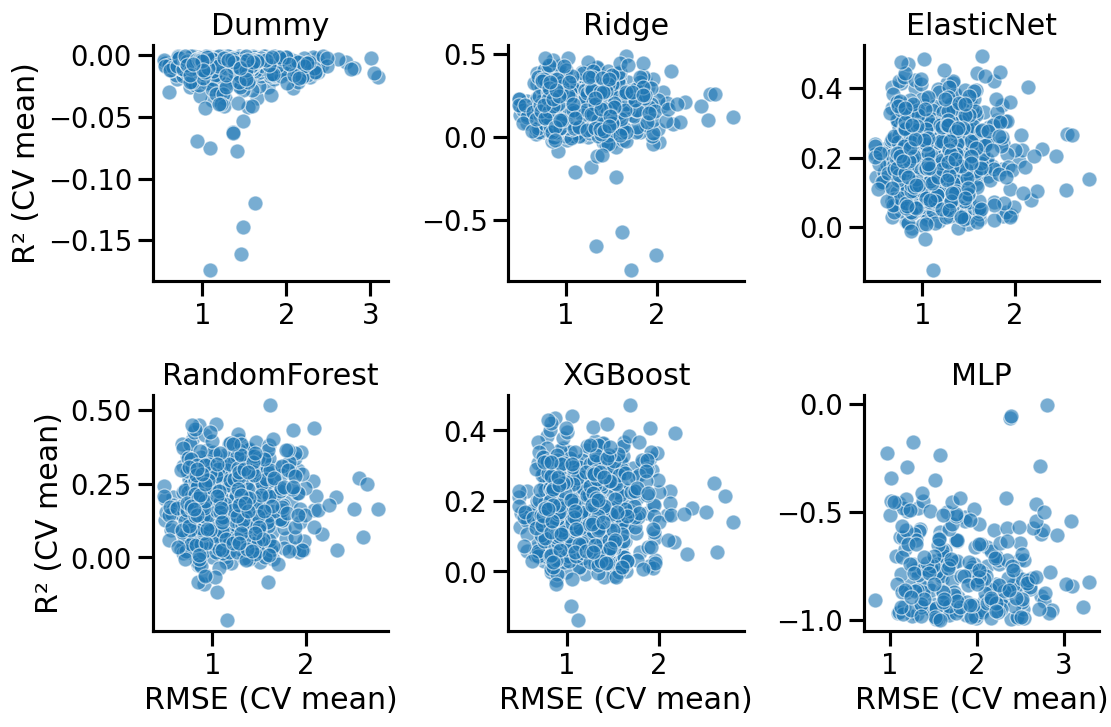

In [9]:
# %%
g = sns.FacetGrid(filtered_df, col="Model", col_wrap=3, sharex=False, sharey=False, height=3.2)
g.map_dataframe(sns.scatterplot, x="rmse_mean", y="r2_mean", alpha=0.6)
g.set_axis_labels("RMSE (CV mean)", "R² (CV mean)")
g.set_titles("{col_name}")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"rmse_vs_r2_scatter_{NUM_PCS}_pcs.png"), dpi=300)
plt.show()


In [10]:
# %%
from itertools import combinations
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel

def _wilcoxon_tie_robust(diffs):
    """
    Wilcoxon signed-rank test that tolerates zero diffs.
    Returns (stat, p). If all diffs are ~0, returns (0.0, 1.0).
    """
    diffs = np.asarray(diffs, dtype=float)
    if np.allclose(diffs, 0):  # everything ties
        return 0.0, 1.0
    # Try Pratt first (keeps zeros); fall back to zsplit if needed.
    try:
        res = wilcoxon(diffs, zero_method="pratt", alternative="two-sided", method="auto")
        stat = getattr(res, "statistic", np.nan)
        pval = getattr(res, "pvalue", getattr(res, "p", np.nan))
        return stat, pval
    except Exception:
        try:
            res = wilcoxon(diffs, zero_method="zsplit", alternative="two-sided", method="auto")
            stat = getattr(res, "statistic", np.nan)
            pval = getattr(res, "pvalue", getattr(res, "p", np.nan))
            return stat, pval
        except Exception:
            return np.nan, np.nan

def paired_table(df, metric="r2_mean", baseline="ElasticNet", higher_is_better=True):
    """
    Pairwise tests vs. `baseline` using per-drug means in `df`.
    For metrics where LOWER is better (e.g., RMSE), set higher_is_better=False.
    Delta is defined so that positive => baseline better.
    """
    wide = df.pivot_table(index="DRUG_ID", columns="Model", values=metric, aggfunc="mean")
    if baseline not in wide.columns:
        raise ValueError(f"Baseline '{baseline}' not found in models: {list(wide.columns)}")

    out = []
    for other in [m for m in wide.columns if m != baseline]:
        pair = wide[[baseline, other]].dropna()
        n = len(pair)
        if n < 5:
            out.append({
                "metric": metric, "baseline": baseline, "other": other, "n": n,
                "delta_mean": np.nan, "wilcoxon_p": np.nan, "ttest_p": np.nan
            })
            continue

        x = pair[baseline].to_numpy(float)
        y = pair[other].to_numpy(float)

        # Delta so that positive means baseline is better
        d = (x - y) if higher_is_better else (y - x)

        # Wilcoxon (tie-robust) + paired t-test
        w_stat, w_p = _wilcoxon_tie_robust(d)
        t_p = ttest_rel(x, y, nan_policy="omit").pvalue

        out.append({
            "metric": metric, "baseline": baseline, "other": other, "n": n,
            "delta_mean": d.mean(), "wilcoxon_p": w_p, "ttest_p": t_p
        })
    return pd.DataFrame(out).sort_values("other")


In [11]:
# R²: higher is better
paired_r2 = paired_table(filtered_df, metric="r2_mean", baseline="ElasticNet", higher_is_better=True)

# RMSE: lower is better
paired_rmse = paired_table(filtered_df, metric="rmse_mean", baseline="ElasticNet", higher_is_better=False)

# Save if you want
paired_r2.to_csv(os.path.join(OUTDIR, f"paired_tests_r2_{NUM_PCS}_pcs.csv"), index=False)
paired_rmse.to_csv(os.path.join(OUTDIR, f"paired_tests_rmse_{NUM_PCS}_pcs.csv"), index=False)

display(paired_r2)
display(paired_rmse)


,metric,baseline,other,n,delta_mean,wilcoxon_p,ttest_p
0,r2_mean,ElasticNet,Dummy,697,0.205462,9.979639e-116,2.507412e-244
1,r2_mean,ElasticNet,MLP,259,1.015930,3.111811e-44,2.543702e-187
2,r2_mean,ElasticNet,RandomForest,697,0.021960,2.170611e-74,1.882851e-80
3,r2_mean,ElasticNet,Ridge,697,0.018840,8.778313e-101,2.314165e-15
4,r2_mean,ElasticNet,XGBoost,697,0.025675,7.337514e-94,1.284817e-127


,metric,baseline,other,n,delta_mean,wilcoxon_p,ttest_p
0,rmse_mean,ElasticNet,Dummy,697,0.153983,9.517705e-116,1.483307e-169
1,rmse_mean,ElasticNet,MLP,259,0.648809,3.111811e-44,2.334597e-124
2,rmse_mean,ElasticNet,RandomForest,697,0.014556,6.906357e-68,1.009163e-68
3,rmse_mean,ElasticNet,Ridge,697,0.011385,2.062558e-96,1.337632e-17
4,rmse_mean,ElasticNet,XGBoost,697,0.019893,6.685990e-94,2.936977e-109
